In [62]:
import matplotlib
matplotlib.use('Agg')
import skimage
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection, imshow_collection
from skimage import color, viewer, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from IPython.display import display
from scipy.ndimage import affine_transform, zoom
from scipy import misc
%matplotlib inline
from PIL import Image
import numpy as np
from io import BytesIO
from IPython.display import display
from sklearn.decomposition import PCA

# CARGAR IMAGEN

453 340 RGB PNG <class 'PIL.PngImagePlugin.PngImageFile'>


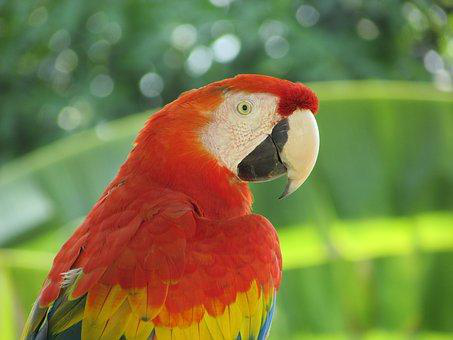

tensor numpy: (340, 453, 3)
Width: 453
Height: 340
Mode: RGB
Format: PNG
Type: <class 'PIL.PngImagePlugin.PngImageFile'>


In [38]:
im = Image.open("Guaca.png")
print(im.width, im.height, im.mode, im.format, type(im))
display(im)
print('tensor numpy:', np.asarray(im).shape)

# Imprimir propiedades de la imagen
print("Width:", im.width)
print("Height:", im.height)
print("Mode:", im.mode)
print("Format:", im.format)
print("Type:", type(im))



# Definir el tamaño de imagen

In [8]:
def imageSize(img):
    img_file = BytesIO()
    image = Image.fromarray(np.uint8(img))
    image.save(img_file, 'png')
    return img_file.tell() / 1024

In [10]:
# Convertir la imagen a un tensor y calcular tamaño
im_array = np.asarray(im)
size_in_kb = imageSize(im_array)
print('Tamaño de la imagen:', size_in_kb, 'KB')

Tamaño de la imagen: 210.2265625 KB


# K MEANS

In [110]:
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

def compress_image(image_path, k):
    # Cargar la imagen
    original_image = Image.open(image_path)
    
    # Convertir la imagen a una matriz NumPy
    image_array = np.array(original_image)

    # Obtener las dimensiones de la imagen
    h, w, _ = image_array.shape

    # Reshape la matriz para que sea compatible con k-means
    reshaped_array = image_array.reshape((h * w, 3))

    # Aplicar k-means
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(reshaped_array)
    labels = kmeans.predict(reshaped_array)
    centroids = kmeans.cluster_centers_

    # Asignar valores RGB de acuerdo a los centroides
    compressed_array = centroids[labels].reshape((h, w, 3)).astype(np.uint8)

    # Crear la imagen comprimida
    compressed_image = Image.fromarray(compressed_array)

    return compressed_image

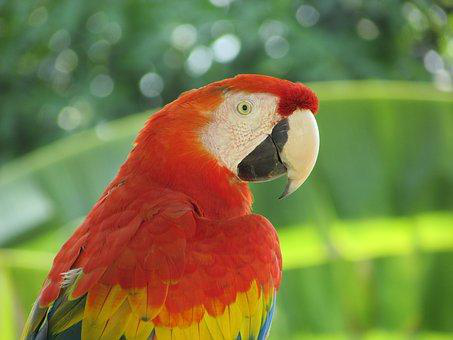

'Imagen Original'

Tamaño de la imagen: 210.2265625 KB


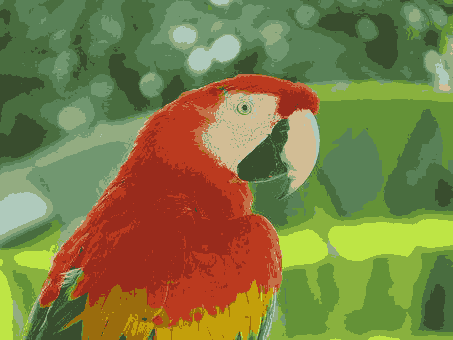

'Imagen Comprimida (k=15)'

Tamaño de la imagen: 29.5224609375 KB


In [111]:
k_clusters = 15

# Comprimir la imagen
compressed_image = compress_image("Guaca.png", k_clusters)

# Mostrar la imagen original y la comprimida
display(im, "Imagen Original")
im_array = np.asarray(im)
size_im = imageSize(im_array)
print('Tamaño de la imagen:', size_im, 'KB')


display(compressed_image, f"Imagen Comprimida (k={k_clusters})")
ci_array = np.asarray(compressed_image)
size_ci = imageSize(ci_array)
print('Tamaño de la imagen:', size_ci, 'KB')

# Comparacion con varios valores de k

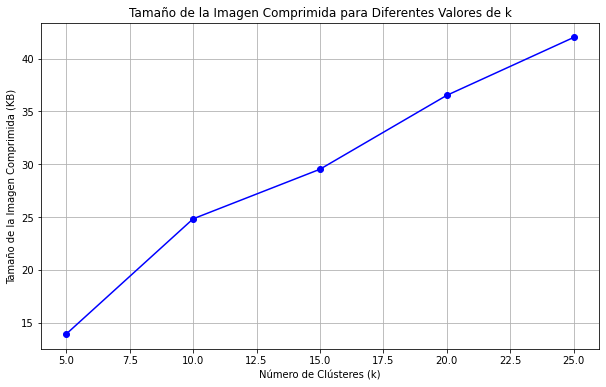

In [75]:
# Ruta de la imagen original
original_image_path = "Guaca.png"

# Cargar la imagen original
original_image = Image.open(original_image_path)
original_array = np.asarray(original_image)
size_original = imageSize(original_array)

k_values = [5, 10, 15, 20, 25]
compressed_sizes = []

# Comprimir la imagen para cada valor de k y almacenar el tamaño comprimido
for k in k_values:
    compressed_image = compress_image(original_image_path, k)
    compressed_array = np.asarray(compressed_image)
    size_compressed = imageSize(compressed_array)
    compressed_sizes.append(size_compressed)

plt.figure(figsize=(10, 6))
plt.plot(k_values, compressed_sizes, marker='o', linestyle='-', color='b')
plt.title('Tamaño de la Imagen Comprimida para Diferentes Valores de k')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Tamaño de la Imagen Comprimida (KB)')
plt.grid(True)
plt.show()

# PCA

In [79]:
def compress_image_pca(image_path, p=None, v=None):
    original_image = Image.open(image_path)
    image_array = np.array(original_image)
    h, w, _ = image_array.shape

    # Obtener matrices 
    X_R = image_array[:, :, 0].reshape((h, w))
    X_G = image_array[:, :, 1].reshape((h, w))
    X_B = image_array[:, :, 2].reshape((h, w))

    # Realizar PCA
    pca_R = PCA(n_components=p, svd_solver='full')
    pca_G = PCA(n_components=p, svd_solver='full')
    pca_B = PCA(n_components=p, svd_solver='full')
    
    X_R_pca = pca_R.fit_transform(X_R)
    X_G_pca = pca_G.fit_transform(X_G)
    X_B_pca = pca_B.fit_transform(X_B)

    # Reconstruir cada canal
    reconstructed_R = np.dot(X_R_pca, pca_R.components_) + pca_R.mean_
    reconstructed_G = np.dot(X_G_pca, pca_G.components_) + pca_G.mean_
    reconstructed_B = np.dot(X_B_pca, pca_B.components_) + pca_B.mean_

    # Crear la imagen comprimida
    compressed_image = np.stack([reconstructed_R, reconstructed_G, reconstructed_B], axis=-1).astype(np.uint8)
    compressed_image = Image.fromarray(compressed_image)

    return compressed_image


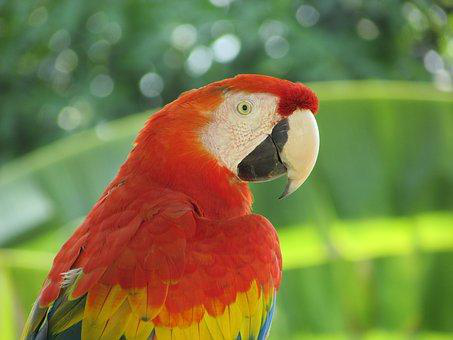

'Imagen Original'

Tamaño de la imagen: 210.2265625 KB


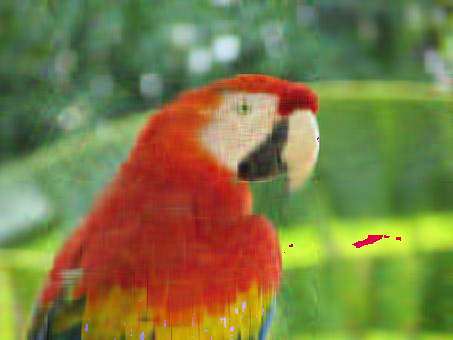

'Imagen Comprimida (P=20)'

Tamaño de la imagen: 174.2060546875 KB


In [106]:
p= 20
compressed_pca = compress_image_pca("Guaca.png", p)

display(im, "Imagen Original")
im_array = np.asarray(im)
size_im = imageSize(im_array)
print('Tamaño de la imagen:', size_im, 'KB')

display(compressed_pca, f"Imagen Comprimida (P={p})")
pca_array = np.asarray(compressed_pca)
size_pca = imageSize(pca_array)
print('Tamaño de la imagen:', size_pca, 'KB')

# Comparacion con varios P

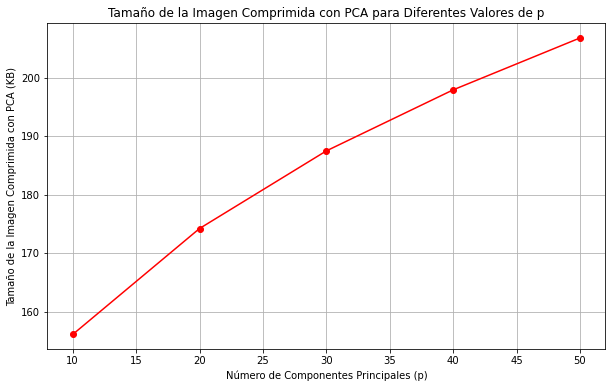

In [109]:
# Ruta de la imagen original
original_image_path = "Guaca.png"
original_image = Image.open(original_image_path)
original_array = np.asarray(original_image)
size_original = imageSize(original_array)

p_values = [10, 20, 30, 40, 50]
compressed_pca_sizes = []

# Comprimir la imagen con PCA para cada valor de p y almacenar el tamaño comprimido
for p in p_values:
    compressed_pca_image = compress_image_pca(original_image_path, p)
    compressed_pca_array = np.asarray(compressed_pca_image)
    size_compressed_pca = imageSize(compressed_pca_array)
    compressed_pca_sizes.append(size_compressed_pca)

plt.figure(figsize=(10, 6))
plt.plot(p_values, compressed_pca_sizes, marker='o', linestyle='-', color='r')
plt.title('Tamaño de la Imagen Comprimida con PCA para Diferentes Valores de p')
plt.xlabel('Número de Componentes Principales (p)')
plt.ylabel('Tamaño de la Imagen Comprimida con PCA (KB)')
plt.grid(True)
plt.show()
